In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

load_dotenv()

import ultron.factor.empyrical as empyrical

from lumina.genetic.metrics.ts_pnl import calculate_ful_ts_ret
from lumina.genetic.signal.method import *
from lumina.genetic.strategy.method import *

from kdutils.macro2 import *
from kdutils.tactix import Tactix


In [27]:
def read_factors(method, instruments, task_id, period, name):
    dirs = os.path.join(base_path, method, instruments, 'temp', "model",
                        str(task_id), str(period))
    filename = os.path.join(dirs, "{0}_predict_data.feather".format(name))
    predict_data = pd.read_feather(filename)
    is_on_mark = predict_data['trade_time'].dt.minute % int(period) == 0
    predict_data = predict_data[is_on_mark]
    predict_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    predict_data.dropna(inplace=True)
    return predict_data

In [28]:
method = 'cicso0'
instruments = 'ims'
task_id = '200037'
period = 5
name = 'linear'

In [29]:
predict_data = read_factors(method=method,
                                instruments=instruments,
                                task_id=task_id,
                                period=period,
                                name=name)
predict_data.head()

,trade_time,code,predict,nxt1_ret_5h
0,2024-12-05 10:20:00,IM,-5.284011,-0.001860
5,2024-12-05 10:25:00,IM,-0.186690,-0.000206
10,2024-12-05 10:30:00,IM,-1.949980,0.003050
15,2024-12-05 10:35:00,IM,-0.980163,0.004669
20,2024-12-05 10:40:00,IM,-5.241567,0.000327


In [30]:
# 将因子值处理成离散值
def rolling_rank_discretization(series, window=24, positive_quantile=0.9, negative_quantile=0.1):
    """
    使用严格的历史滚动窗口进行排名离散化，避免任何未来数据。

    参数:
    series: 输入数据，Pandas Series。
    window: 滚动窗口大小（默认10）。
    positive_quantile: 正方向分位数阈值（默认0.9）。
    negative_quantile: 负方向分位数阈值（默认0.1）。

    返回:
    discrete_series: 离散化后的Series，值为-1, 0, 1。
    """
    # 初始化结果Series
    discrete_series = pd.Series(index=series.index, dtype=float)
    
    # 遍历每个窗口
    for i in range(len(series)):
        if i < window - 1:
            # 窗口不足时设置为NaN
            discrete_series.iloc[i] = np.nan
            continue
            
        # 获取当前窗口数据 (严格使用过去window个点)
        window_data = series.iloc[i - window + 1: i + 1] # 包括当前点，但都是历史数据
        
        # 跳过包含NaN值的窗口
        if window_data.isna().any():
            discrete_series.iloc[i] = np.nan
            continue
        
        # 在窗口内计算排名标准化
        rank_data = window_data.rank()
        standardized = (rank_data / rank_data.sum()) - 0.5
        
        # 计算当前窗口的分位数阈值
        pos_threshold = standardized.quantile(positive_quantile)
        neg_threshold = standardized.quantile(negative_quantile)
        
        # 对窗口内的最后一个值（即当前点）进行离散化
        current_standardized = standardized.iloc[-1]
        if current_standardized >= pos_threshold:
            discrete_series.iloc[i] = 1
        elif current_standardized <= neg_threshold:
            discrete_series.iloc[i] = -1
        else:
            discrete_series.iloc[i] = 0
    
    return discrete_series

In [31]:
# 处理成离散值
predict_data['pred_alpha_disc'] = predict_data.groupby('code').apply(lambda x: rolling_rank_discretization(
    x['predict'], window=24, positive_quantile=0.7, negative_quantile=0.3)).T
predict_data = predict_data.dropna(subset=['pred_alpha_disc'])
predict_data.head()

,trade_time,code,predict,nxt1_ret_5h,pred_alpha_disc
115,2024-12-05 13:45:00,IM,-1.972368,0.000140,0.0
120,2024-12-05 13:50:00,IM,-5.112900,-0.001437,-1.0
125,2024-12-05 13:55:00,IM,-5.725995,0.000901,-1.0
130,2024-12-05 14:00:00,IM,-4.680115,-0.005112,-1.0
135,2024-12-05 14:05:00,IM,1.150667,0.005232,1.0


In [32]:
from lib.cux001 import FactorEvaluate1

In [37]:
evaluate1 = FactorEvaluate1(factor_data=predict_data,
                                factor_name='pred_alpha_disc',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=240,
                                fee=0.000023,
                                scale_method='raw',
                                expression=name)

In [38]:
stats_dt = evaluate1.run()

In [39]:
stats_dt

{'total_ret': 0.05091825211165979,
 'avg_ret': 1.80277389515374e-05,
 'max_dd': -0.0832343274515921,
 'calmar': 0.61174582255468,
 'sharpe1': 0.010679909275433554,
 'sharpe2': 1.0382378143983544,
 'turnover': 0.8860294117647058,
 'win_rate': 0.2947860962566845,
 'profit_ratio': 1.0424147733619067,
 'ic_mean': 0.03194690934159401,
 'ic_std': 0.07257954143096589,
 'ic_ir': 0.44016411114942566,
 'factor_autocorr': -0.1036090287133599,
 'ret_autocorr': -0.03730132509536459}

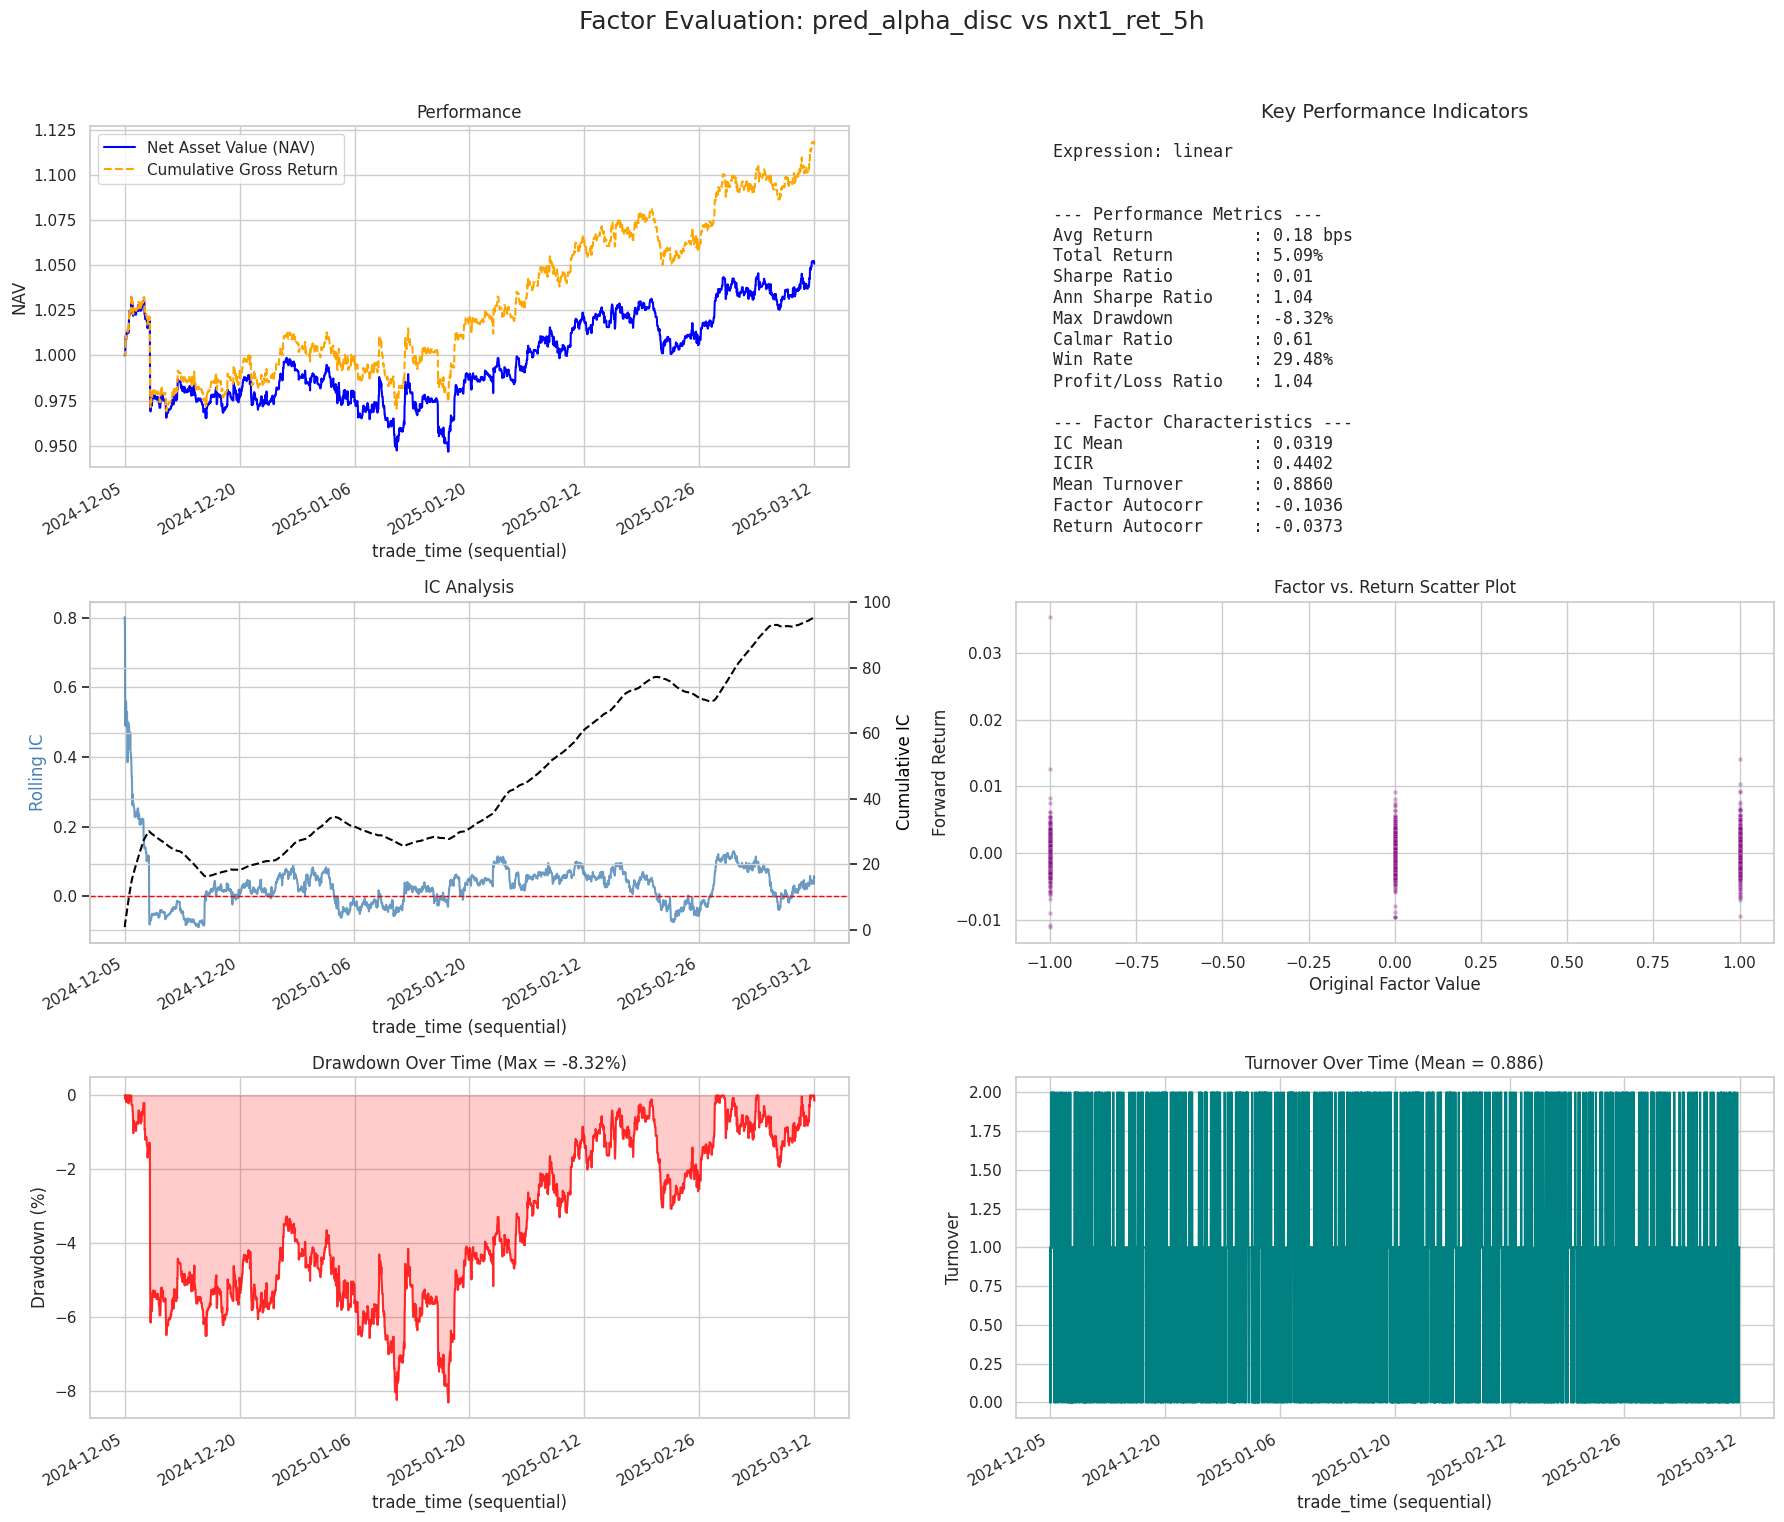

In [40]:
evaluate1.plot_results()

In [1]:
import pandas as pd

<Axes: xlabel='trade_time'>

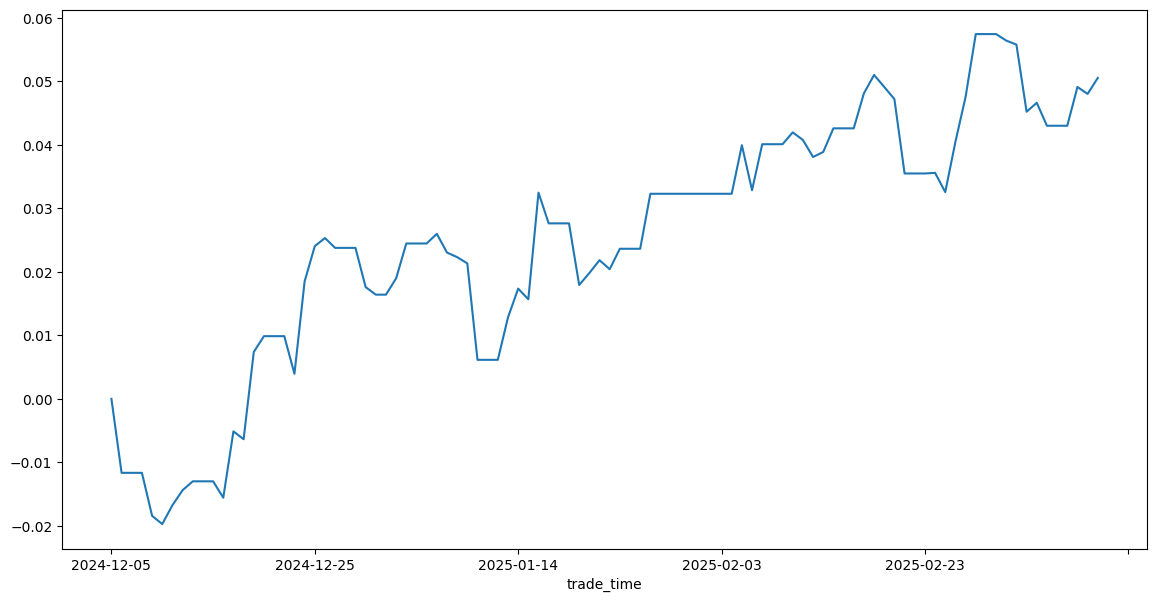

In [7]:
pd.read_csv('1.csv',index_col=0).set_index('trade_time')['a_ret'].cumsum().plot(figsize=(14,7))